In [1]:
import xarray as xr


from matplotlib import pyplot as plt
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_harmonics import RealSHT, InverseRealSHT
import cartopy.crs as ccrs
from os.path import join
import os
import yaml
from glob import glob
from credit.xr_sampler import XRSamplerByYear
import multiprocessing
from functools import partial

In [ ]:
rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train/forecast"


# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/fcnn_6_12h/forecast"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/fcnn_6_12h_train_filter/forecast"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/base_skebs_untrained/forecast"


compute_truth = False
num_cpus = 15
config = join(os.path.dirname(rollout_dir), "model.yml")
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

static_ds = xr.open_dataset(conf["data"]["save_loc_static"])


In [3]:
# setup transforms
# Create equiangular grid parameters
nlat = len(static_ds.latitude)
nlon = len(static_ds.longitude)

# Initialize spherical harmonic transform
lmax = nlat + 1 # Maximum degree for the transform


sht = RealSHT(nlat, nlon, lmax=lmax, grid="equiangular", norm="ortho")
isht = InverseRealSHT(nlat, nlon, lmax=lmax, grid="equiangular", norm="ortho")

In [4]:
sampler = XRSamplerByYear("/glade/derecho/scratch/dkimpara/CREDIT_runs/camulator_weather_rollout/model.yml")

def get_data(rollout_files, variable, level, truth=False):
    def select_darray(ds_given):
        ds_sel = ds_given[variable]
        if variable in "UVTQtot":
            return ds_sel.isel(level=level)
        return ds_sel
    
    # get pred and true data
    pred_da_list = []
    true_da_list = []
    for file in rollout_files:
        ds = xr.open_dataset(file)
        da = select_darray(ds)
        pred_da_list.append(da)
        
        if truth:
            da_true = select_darray(sampler(da.time.values[0]))
            true_da_list.append(da_true)
    da_pred = xr.concat(pred_da_list, dim='time')

    if truth:
        da_true = xr.concat(true_da_list, dim='time')
        return da_pred, da_true
    else:
        return (da_pred, )

In [5]:
def compute_zonal_spectrum(da):
    data = torch.tensor(da.values, dtype=torch.float64)
    coeffs = sht(data)
    c_dims = len(coeffs.shape)
    # reshape = [1, ] * (c_dims - 2) + list(coeffs.shape[-2:])
    # lower_triangle = torch.tril(torch.ones(coeffs.shape[-2:]), diagonal=0).view(reshape)
    ### compute zonal spectra
    # square then multiply everything but l=0 by 2
    times_two = 2. * torch.ones(coeffs.shape[-1])
    times_two[0] = 1.
    avg_zonal_power = ((torch.abs(coeffs ** 2) * times_two)
                       .sum(dim=-2)
                       .mean(dim=list(range(len(coeffs.shape) - 2))) # mean along all batch dimensions
    )
    
     # sum over ls
    return avg_zonal_power


In [6]:
def aggregate_zonal_spectrum(eval_fh, variable, level, truth=False):
    rollout_files = glob(join(rollout_dir, "/out_2012" + f"*/pred_*{eval_fh:03}.nc")) + glob(join(rollout_dir, "out_2013" + f"*/pred_*{eval_fh:03}.nc"))
    # rollout_files = glob(join(rollout_dir, "2012" + f"*/pred_*{eval_fh:03}.nc")) + glob(join(rollout_dir, "2013" + f"*/pred_*{eval_fh:03}.nc"))
    data = get_data(rollout_files, variable, level, truth=truth)
    average_power = compute_zonal_spectrum(data[0])

    if not truth:
        return average_power
    
    # else compute truth power
    true_average_power = compute_zonal_spectrum(data[1])
    return average_power, true_average_power

# save out spectra for pred and true
def pack_into_da(data, variable, level):
    fh_index = xr.DataArray(
        np.array(forecast_hours), dims="fh"
    )
    data = torch.stack(data).unsqueeze(1)
    da = xr.DataArray(
        data=data.cpu().detach().numpy(),
        dims=['fh', 'level', 'wavenumber'],
        coords={
            'fh': fh_index,
            'level': [level],
            'wavenumber': np.arange(1, data.shape[-1]+1),

        },
        name=variable
    )
    return da

In [7]:
last_forecast_hour = 240
fh_interval = 12
forecast_hours = list(range(6, last_forecast_hour + 1, 6))

forecast_hours = [12, 24, 36, 48, 72, 96, 120, 240]

# variables = ["U", "V"]
# levels = [19, 20]
variables = ["U", "V"]
levels = [19, 20, 24]

true_das = {k: [] for k in variables}
pred_das = {k: [] for k in variables}

for variable in variables:
    for level in levels:
        f = partial(aggregate_zonal_spectrum, variable=variable, level=level, truth=compute_truth)
        with multiprocessing.Pool(num_cpus) as p:
            result = p.map(f, forecast_hours) #result list corresponding to fhs
        
        if not compute_truth:
            pred = result
        else:
            pred, true = list(zip(*result)) #output is a list of torch tensors of the power spectrum
            true_das[variable].append(pack_into_da(true, variable, level))
        
        pred_das[variable].append(pack_into_da(pred, variable, level))


concat_das = {k: xr.concat(pred_das[k], dim="level") for k in variables}
ds = xr.Dataset(concat_das)

if compute_truth:
    concat_true_das = {k: xr.concat(true_das[k], dim="level") for k in variables}
    true_ds = xr.Dataset(concat_true_das)


In [8]:
# save calculations
# ds.to_netcdf(join(rollout_dir, "UVzonal_spec_camulator_ref_2012-06-05_10dayforecast_8dayinterval.nc"))
# true_ds.to_netcdf(join(rollout_dir, "UVzonal_spec_cam_ref_2012-06-05_10dayforecast_8dayinterval.nc"))

In [9]:
ds_camulator = xr.open_dataset("/glade/derecho/scratch/dkimpara/CREDIT_runs/camulator_weather_rollout/UVzonal_spec_camulator_ref_2012-06-05_10dayforecast_8dayinterval.nc")
ds_cam = xr.open_dataset("/glade/derecho/scratch/dkimpara/CREDIT_runs/camulator_weather_rollout/UVzonal_spec_cam_ref_2012-06-05_10dayforecast_8dayinterval.nc")

#to debug
# ds_camulator = ds
# ds_cam = true_ds

spec_camulator = 0.5 * (ds_camulator.U + ds_camulator.V)
spec_cam = 0.5 * (ds_cam.U + ds_cam.V).mean(dim="fh")
spec_pred = 0.5 * (ds.U + ds.V)


In [16]:
def plot_all_fh(level):
    plt.loglog(spec_cam.wavenumber, spec_cam.sel(level=level), c='0', label='cam')
    
    plt.loglog(spec_camulator.wavenumber, spec_camulator.sel(level=level, fh=forecast_hours[0]), label="det camulator mean spectrum")
    plt.loglog(spec_pred.wavenumber, spec_pred.sel(level=level).mean(dim="fh"), c='r', label='skebs camulator')

    alphas = 1 / (np.arange(len(forecast_hours[1:])) + 1)
    
    for fh,alpha in zip(forecast_hours[1:], alphas):
        plt.loglog(spec_camulator.wavenumber, spec_pred.sel(level=level, fh=fh), linewidth=alpha*5)
    plt.axvline(100)
    plt.title(f"KE spectrum level {level}")
    plt.legend()
    plt.grid(True)
    plt.xlim(1)
    plt.show()
    
def plot(level, fh):
    plt.loglog(spec_cam.wavenumber, spec_cam.sel(level=level), c='0', label='cam')
    plt.axvline(100)

    plt.loglog(spec_camulator.wavenumber, spec_camulator.sel(level=level, fh=fh), label="det camulator")
    plt.loglog(spec_pred.wavenumber, spec_pred.sel(level=level, fh=fh), c='r', label='skebs camulator')
    plt.title(f"{fh}h KE spectrum level {level}")
    plt.legend()
    plt.grid(True)
    plt.xlim(1)
    plt.show()

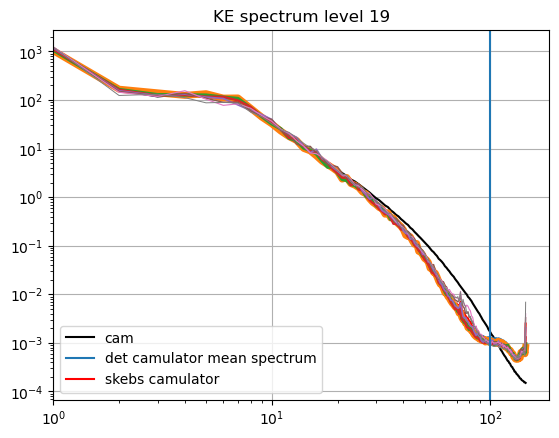

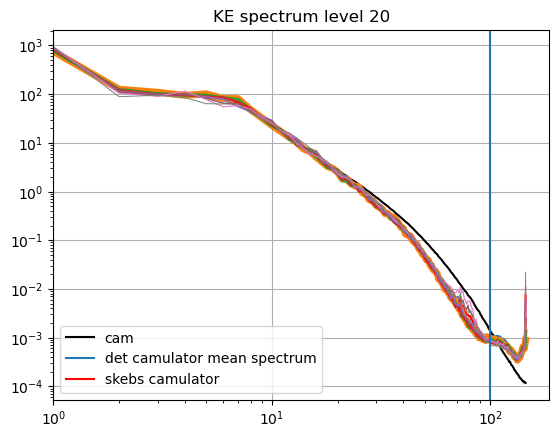

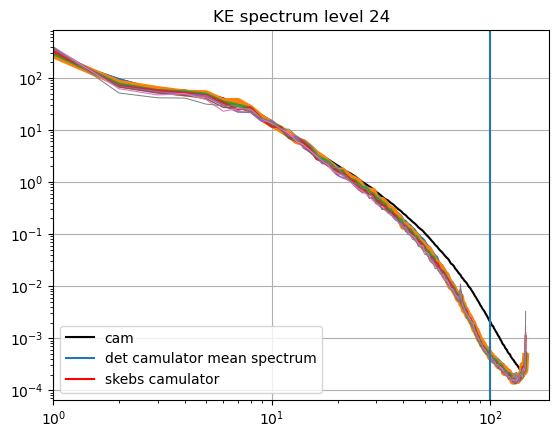

In [17]:
plot_all_fh(19)
plot_all_fh(20)
plot_all_fh(24)

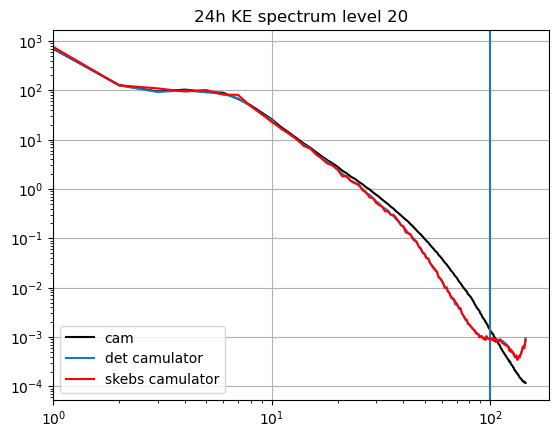

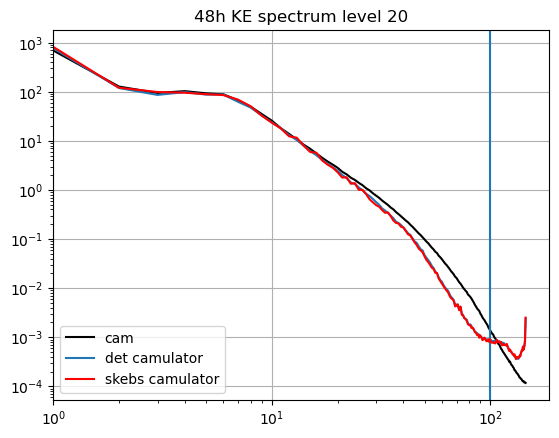

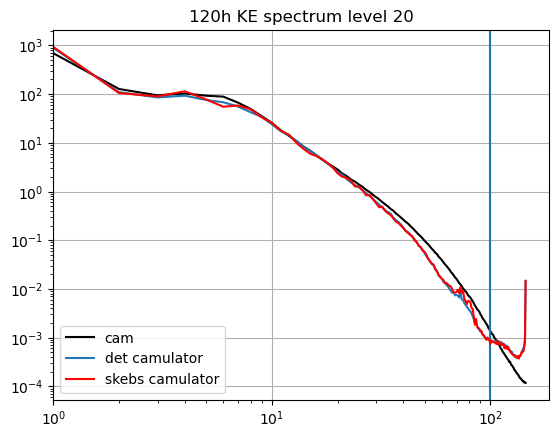

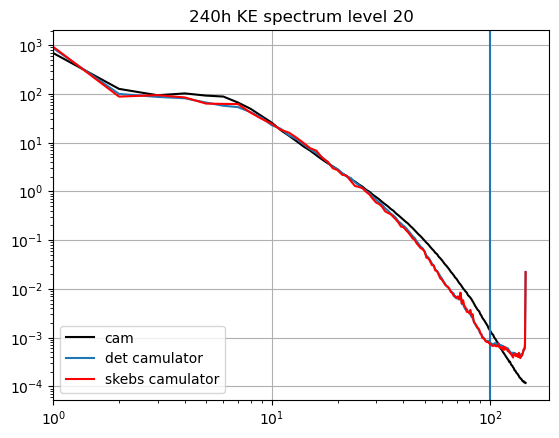

In [18]:
plot(20, 24)
plot(20, 48)
plot(20, 120)
plot(20, 240)


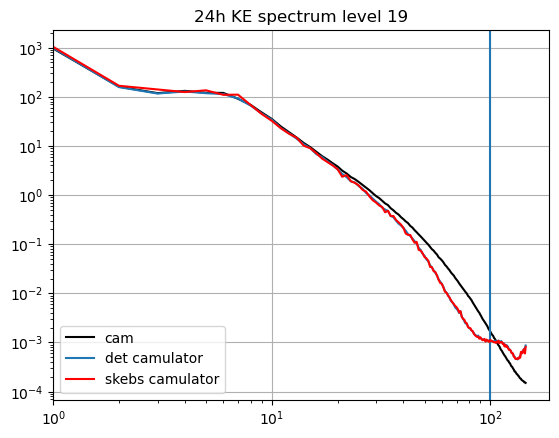

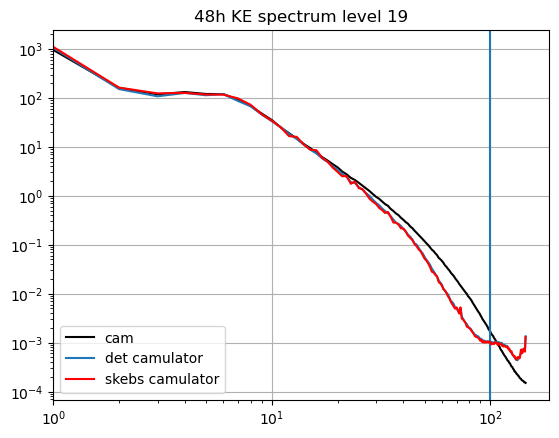

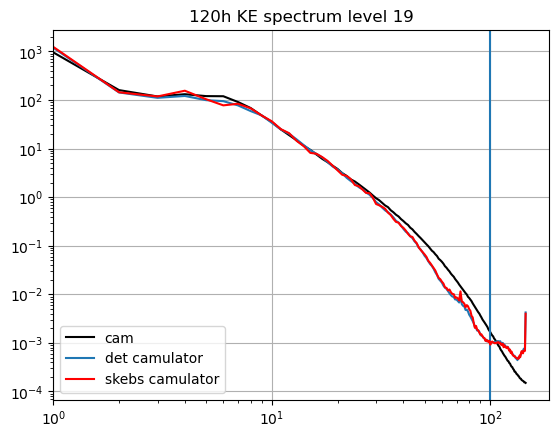

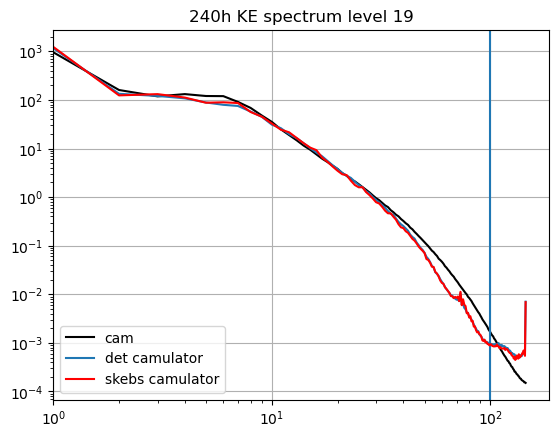

In [19]:
plot(19, 24)
plot(19, 48)
plot(19, 120)
plot(19, 240)


In [14]:
def plotU(level, fh):
    plt.loglog(spec_camulator.wavenumber, ds_camulator.U.sel(level=level, fh=fh), label="det camulator")
    plt.loglog(spec_cam.wavenumber, ds_cam.U.sel(level=level, fh=fh), c='0', label='cam')
    plt.loglog(spec_pred.wavenumber, ds.U.sel(level=level, fh=fh), c='r', label='skebs camulator')
    plt.title(f"{fh}h KE spectrum level {level}")
    plt.legend()
    plt.grid(True)
    plt.xlim(1)
    plt.show()

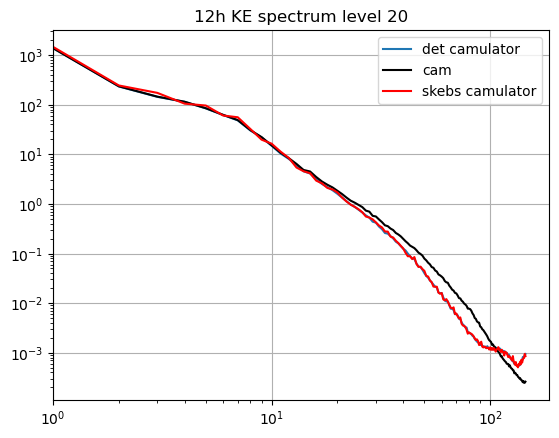

In [15]:
plotU(20,12)